# Generate data to ML models
Generate the data to ML models. For this example only ficticious data are generated acording a certain formula (also ficticous that try to represent the problem of process that generate an output and this output pass across a tank and then go to another tank)

## Root folder and read env variables

In [1]:
import os
# fix root path to save outputs
actual_path = os.path.abspath(os.getcwd())
list_root_path = actual_path.split('\\')[:-1]
root_path = '\\'.join(list_root_path)
os.chdir(root_path)
print('root path: ', root_path)

root path:  D:\github-mi-repo\Gurobi-ML-tips-modeling


In [2]:
import os
from dotenv import load_dotenv, find_dotenv # package used in jupyter notebook to read the variables in file .env

""" get env variable from .env """
load_dotenv(find_dotenv())

""" Read env variables and save it as python variable """
PROJECT_GCP = os.environ.get("PROJECT_GCP", "")

## RUN

In [3]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import gcsfs
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# import warnings
# warnings.filterwarnings("ignore")

In [4]:
# ### desarrollo

# PROJECT_ID = PROJECT_GCP
# ! gcloud config set project $PROJECT_ID

### 0. Paramaters

In [5]:
len_data = 1000

### 1. Read Master Table

In [6]:
path_master_table = f'config/MasterTable.xlsx'
master_table = pd.read_excel(path_master_table)
master_table

,TAG,FEATURES_NAMES,DESCRIPCION,CLASIFICACION_NAME,CLASIFICACION,USE_ACTUAL_MODEL
0,X1,X1,Variable de entrada al proceso A. Variable Pri...,Primary,P,MLA
1,O1,O1,Variable de entrada al proceso A. No es una va...,Observed,O,MLA
2,O2,O2,Variable de entrada al proceso A. No es una va...,Observed,O,MLA
3,O3,O3,Variable de entrada al proceso A. No es una va...,Observed,O,MLA
4,Y1,Y1,Variable target del proceso A y Variable de en...,Target,T,MLA
5,Z1,Z1,Variable de salida del tanque X y Variable de ...,Secundary,S,MLB
6,X2,X2,Variable de entrada al proceso B. Aparece por ...,Primary,P,MLB
7,O4,O4,Variable de entrada al proceso tanque TANK1. N...,Observed,O,TANK1
8,O5,O5,Variable de entrada al proceso B. No es una va...,Observed,O,MLB
9,O6,O6,Variable de entrada al proceso B. No es una va...,Observed,O,MLB


### 2. Define data random features and target
Define data random and create a formula to map the features into a target and then generate random data to append to the target

#### 2.1 Process A

In [7]:
list_features_process_a = [
    "X1",
    "O1",
    "O2",
    "03"
]

list_target_process_a = ["Y1"]

In [8]:
##### FEATURES

# generate data features process_a
np.random.seed(42)
values_features_process_a = 100 * np.random.rand(len_data, len(list_features_process_a))

In [9]:
#### TARGET y = f(x)

# define contribution of each feature into target value
# formula_target_process_a = (np.exp(-1/values_features_process_a) + np.log(values_features_process_a)).sum(axis = 1) # all features
contribution_target_process_a_feature_0 = 15 * (np.exp(-1/values_features_process_a[:, 0]) + np.log(values_features_process_a[:, 0]))
contribution_target_process_a_feature_1 = -4 * (np.exp(-1/values_features_process_a[:, 1]))
contribution_target_process_a_feature_2 = -1/3 * (np.exp(np.log(values_features_process_a[:, 2])))
contribution_target_process_a_feature_3 = -1/3 * (values_features_process_a[:, 3])

# generate target -> sum individual contributions
formula_target_process_a = contribution_target_process_a_feature_0 + contribution_target_process_a_feature_1 + \
                            contribution_target_process_a_feature_2 + contribution_target_process_a_feature_3

# generate noise to add to the formula of the target generated
np.random.seed(52)
noise_target_process_a = 10 * np.random.rand(len_data, len(list_target_process_a))

In [10]:
# GENERATE DATA_TARGET PROCESS A

# generarte dataframe features_target
values_target_process_a  = formula_target_process_a.reshape(formula_target_process_a.shape[0], 1) + noise_target_process_a
data_process_a = pd.DataFrame(values_features_process_a, columns = list_features_process_a)
data_process_a[list_target_process_a] = values_target_process_a

# change values to not have negartive values -this data try to represent a physical process
data_process_a = data_process_a + np.abs(data_process_a.min())

data_process_a

,X1,O1,O2,03,Y1
0,37.467481,95.270644,73.200558,60.013231,99.845222
1,15.615333,15.798666,5.809525,86.764997,91.956321
2,60.124970,71.006471,2.059613,97.138367,112.318699
3,83.257733,21.433125,18.183660,18.487833,142.317317
4,30.437694,52.674857,43.195665,29.270296,109.671948
...,...,...,...,...,...
995,83.249823,80.764094,22.433019,22.755289,135.164129
996,81.744001,93.239056,9.537256,45.153246,132.995228
997,33.758897,87.268059,8.353655,21.259976,129.397887
998,75.260303,5.328598,49.254702,44.358086,124.431951


In [11]:
# ## corr data
data_process_a.corr()['Y1']

X1    0.629808
O1   -0.026350
O2   -0.477447
03   -0.463847
Y1    1.000000
Name: Y1, dtype: float64

array([[<Axes: title={'center': 'X1'}>, <Axes: title={'center': 'O1'}>],
       [<Axes: title={'center': 'O2'}>, <Axes: title={'center': '03'}>],
       [<Axes: title={'center': 'Y1'}>, <Axes: >]], dtype=object)

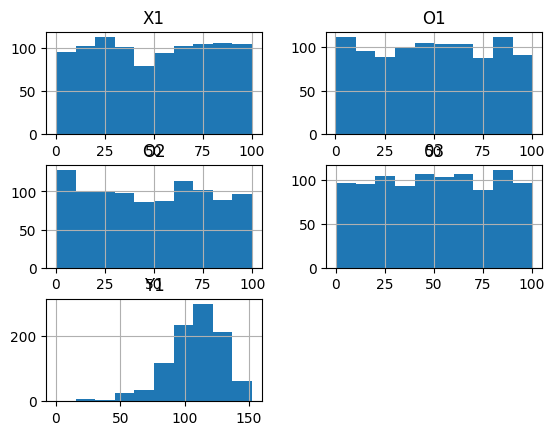

In [41]:
# hist all data
data_process_a.hist()

<Axes: >

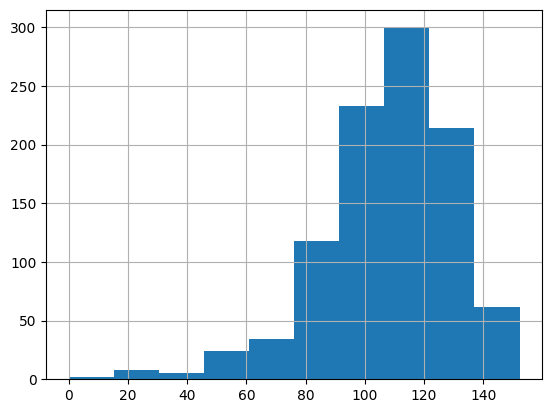

In [12]:
# histogram target
data_process_a['Y1'].hist()

#### 2.2 Process B - target Y2
Process B that see Z1, X2, O5, O6 and generate the target y2. That target is also shared with the output of the process C

In [13]:
list_features_process_b_y2 = [
    "Z1",
    "X2",
    "O5",
    "O6"
]

list_target_process_b_y2 = ["Y2"]

In [14]:
##### FEATURES

# generate data features process_b_y2
np.random.seed(62)

values_features_process_b_y2_secondary = np.array(data_process_a["Y1"]) # the input in the tank is the same if the volume is constant
values_features_process_b_y2_secondary = np.expand_dims(values_features_process_b_y2_secondary, axis = 1)
values_features_process_b_y2_primary_observed = 10 * np.random.rand(len_data, len(list_features_process_b_y2)-1)

values_features_process_b_y2 = np.concatenate((values_features_process_b_y2_secondary, values_features_process_b_y2_primary_observed), axis = 1) 

In [15]:
#### TARGET y = f(x)

# define contribution of each feature into target value
# formula_target_process_b_y2 = (np.exp(-1/values_features_process_b_y2) + np.log(values_features_process_b_y2)).sum(axis = 1) # all features
contribution_target_process_b_y2_feature_0 = 1/3 * values_features_process_b_y2[:, 0]
contribution_target_process_b_y2_feature_1 = 15 * (np.exp(-1/values_features_process_b_y2[:, 1]))
contribution_target_process_b_y2_feature_2 = 2 * (np.exp(np.log(values_features_process_b_y2[:, 2])))
contribution_target_process_b_y2_feature_3 = -1/10 * (values_features_process_b_y2[:, 3])

# generate target -> sum individual contributions
formula_target_process_b_y2 = contribution_target_process_b_y2_feature_0 + contribution_target_process_b_y2_feature_1 + \
                            contribution_target_process_b_y2_feature_2 + contribution_target_process_b_y2_feature_3

# generate noise to add to the formula of the target generated
np.random.seed(12)
noise_target_process_b_y2 = 10 * np.random.rand(len_data, len(list_target_process_b_y2))

In [16]:
# GENERATE DATA_TARGET PROCESS B y2

# generate data target process_b_y2
values_target_process_b_y2  = formula_target_process_b_y2.reshape(formula_target_process_b_y2.shape[0], 1) + noise_target_process_b_y2
data_process_b_y2 = pd.DataFrame(values_features_process_b_y2, columns = list_features_process_b_y2)
data_process_b_y2[list_target_process_b_y2] = values_target_process_b_y2

data_process_b_y2

,Z1,X2,O5,O6,Y2
0,99.845222,0.337547,4.891075,8.460851,44.534739
1,91.956321,4.114020,6.314154,2.909432,62.153203
2,112.318699,5.428003,2.281814,2.402763,56.872237
3,142.317317,9.534575,6.458104,0.178572,79.181320
4,109.671948,9.961258,7.351945,7.219425,64.252297
...,...,...,...,...,...
995,135.164129,7.676773,8.853379,5.622381,82.016784
996,132.995228,7.624778,8.860129,6.958882,74.616505
997,129.397887,2.902402,6.884758,1.397521,76.073244
998,124.431951,0.359562,8.983187,2.696323,67.730164


In [17]:
# ## corr data
data_process_b_y2.corr()['Y2']

Z1    0.717116
X2    0.316397
O5    0.561734
O6   -0.034461
Y2    1.000000
Name: Y2, dtype: float64

array([[<Axes: title={'center': 'Z1'}>, <Axes: title={'center': 'X2'}>],
       [<Axes: title={'center': 'O5'}>, <Axes: title={'center': 'O6'}>],
       [<Axes: title={'center': 'Y2'}>, <Axes: >]], dtype=object)

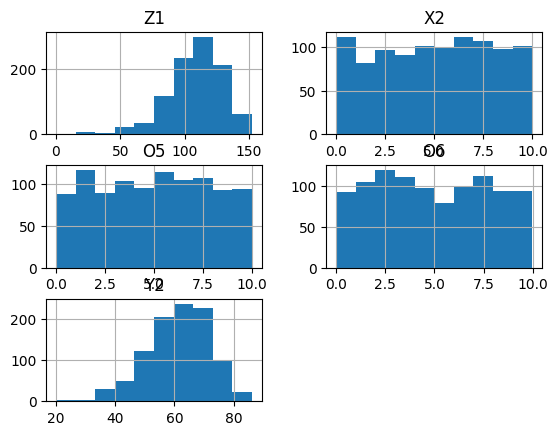

In [18]:
# hist all features
data_process_b_y2.hist()

<Axes: >

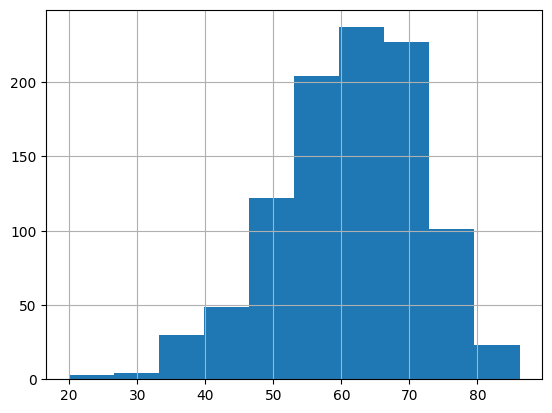

In [19]:
# histogram target
data_process_b_y2['Y2'].hist()

#### 2.3 Process C
This process has its own formula as ml models. 

- To use this formula in gurobi it is necesary define the formula directly as constraint. So, the formula used here is the original formula that will be used as "model"

- Also, according the diagram of the process that we try to modelate, the target of this process needs to be the same target of the process B

In [20]:
list_features_process_c = [
    "X3",
    "07",
]

list_target_process_c = ["Y2"]

In [21]:
#### TARGET

# the target of the process needs to be the same of the target of process B
values_target_process_c = np.array(data_process_b_y2["Y2"])
values_target_process_c = np.expand_dims(values_target_process_c, axis = 1)

In [22]:
##### FEATURES - fixed one feature and the another feature is calcualated according the alpha defined

# generate data feature 1 process_c 
np.random.seed(62)
values_features_process_c_feature1 = 10 * np.random.rand(len_data, len(list_features_process_c)-1)

# the features needs a parameter alpha in the formula that maps this values into the target
alpha_feature_1 = 1/5
alpha_feature_2 = 15
values_features_process_c_feature2 = (values_target_process_c - alpha_feature_1 * values_features_process_c_feature1) / alpha_feature_2
#values_features_process_c_feature2[values_features_process_c_feature2 < 0] = 0

values_features_process_c = np.concatenate((values_features_process_c_feature1, values_features_process_c_feature2), axis = 1)

In [23]:
# generate dataframe process_c
data_process_c = pd.DataFrame(values_features_process_c, columns = list_features_process_c)
data_process_c[list_target_process_c] = values_target_process_c
data_process_c

,X3,07,Y2
0,0.337547,2.964482,44.534739
1,4.891075,4.078333,62.153203
2,8.460851,3.678671,56.872237
3,4.114020,5.223901,79.181320
4,6.314154,4.199298,64.252297
...,...,...,...
995,4.983054,5.401345,82.016784
996,3.887887,4.922595,74.616505
997,5.537505,4.997716,76.073244
998,4.707576,4.452577,67.730164


In [24]:
data_process_c.min()

X3     0.000558
07     1.264729
Y2    19.913116
dtype: float64

array([[<Axes: title={'center': 'X3'}>, <Axes: title={'center': '07'}>],
       [<Axes: title={'center': 'Y2'}>, <Axes: >]], dtype=object)

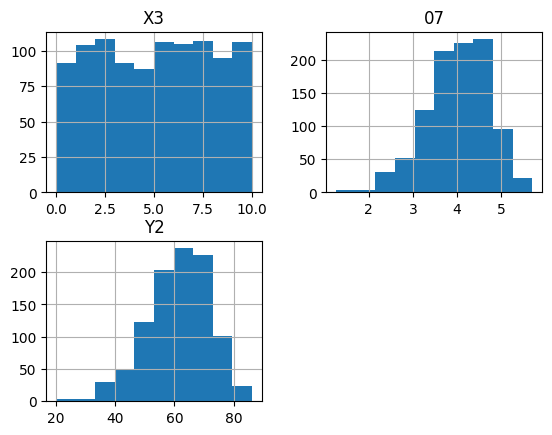

In [25]:
data_process_c.hist()

In [26]:
data_process_c.corr()['Y2']

X3   -0.045602
07    0.998532
Y2    1.000000
Name: Y2, dtype: float64

<Axes: >

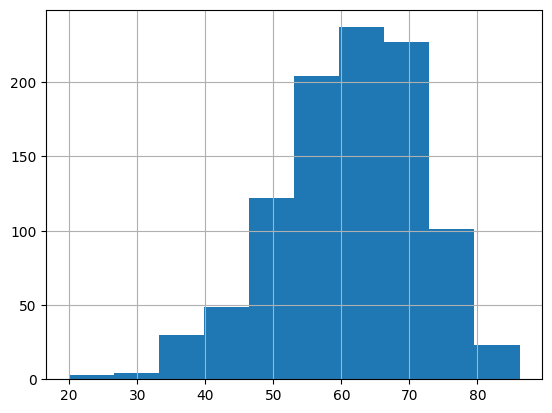

In [27]:
# hist target
data_process_c['Y2'].hist()

#### 2.4 Process B - target Y3
Process B that see Z1, X2, and generate the target y3. 
See that the process B has 2 targets.
See that to generate target y3 it is necesary only the features Z1 and X2 and it is not necesary the features O5 and O6

In [28]:
list_features_process_b_y3 = [
    "Z1",
    "X2"
]

list_target_process_b_y3 = ["Y3"]

In [29]:
##### FEATURES - the features are already generated
data_process_b_y3 = data_process_b_y2[list_features_process_b_y3]
data_process_b_y3.head()

,Z1,X2
0,99.845222,0.337547
1,91.956321,4.114020
2,112.318699,5.428003
3,142.317317,9.534575
4,109.671948,9.961258


In [30]:
#### TARGET y = f(x)

# define contribution of each feature into target value
contribution_target_process_b_y3_feature_1 = 2 * (np.exp(np.log( data_process_b_y3.iloc[:, 0] )))
contribution_target_process_b_y3_feature_2 = -1/10 * data_process_b_y3.iloc[:, 1]

# generate target -> sum individual contributions
formula_target_process_b_y3 = contribution_target_process_b_y3_feature_1 + contribution_target_process_b_y3_feature_2

D:\Anaconda\envs\data-science-python-3-10-gurobi\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [31]:
# GENERATE DATA_TARGET PROCESS B y3
values_target_process_b_y3  = np.array(formula_target_process_b_y3)
data_process_b_y3.loc[:, 'Y3'] = values_target_process_b_y3

data_process_b_y3

C:\Users\JORTEGAL\AppData\Local\Temp\ipykernel_3904\2602898210.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_process_b_y3.loc[:, 'Y3'] = values_target_process_b_y3


,Z1,X2,Y3
0,99.845222,0.337547,199.656689
1,91.956321,4.114020,183.501239
2,112.318699,5.428003,224.094597
3,142.317317,9.534575,283.681177
4,109.671948,9.961258,218.347769
...,...,...,...
995,135.164129,7.676773,269.560580
996,132.995228,7.624778,265.227978
997,129.397887,2.902402,258.505533
998,124.431951,0.359562,248.827945


<Axes: >

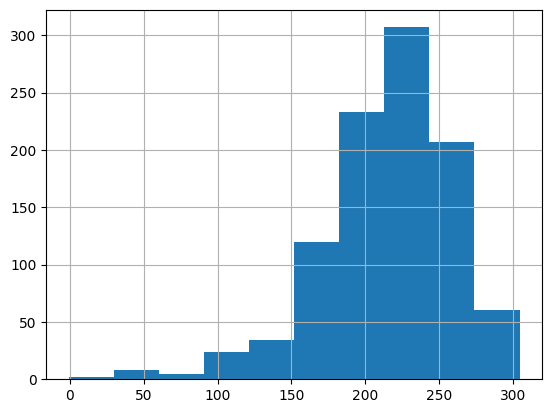

In [32]:
# histogram target
data_process_b_y3['Y3'].hist()

### 3. Evaluate capacity of ml model and split data
Evaluate the capacity of a Machine Learning model to predict this data. For this example it will use only a simple linear regression

#### 3.1 Process A

In [33]:
# list features-target
features_train_process_a = data_process_a.columns.tolist()[0:-1]
target_process_a = data_process_a.columns.tolist()[-1]

# generate data
X_process_a = data_process_a[features_train_process_a]
y_process_a = data_process_a[target_process_a]

# split train test
X_train_process_a, X_test_process_a, y_train_process_a, y_test_process_a = train_test_split(X_process_a,
                                                                                            y_process_a,
                                                                                            test_size = 0.2,
                                                                                            random_state = 42
                                                                                           )

# train model
lr_process_a = LinearRegression()
lr_process_a.fit(X_train_process_a, y_train_process_a)

# evaluate
lr_process_a.score(X_test_process_a, y_test_process_a)

0.8185721127557078

#### 3.2 Process B y2

In [34]:
# list features-target
features_train_process_b_y2 = data_process_b_y2.columns.tolist()[0:-1]
target_process_b_y2 = data_process_b_y2.columns.tolist()[-1]

# generate data
X_process_b_y2 = data_process_b_y2[features_train_process_b_y2]
y_process_b_y2 = data_process_b_y2[target_process_b_y2]

X_train_process_b_y2, X_test_process_b_y2, y_train_process_b_y2, y_test_process_b_y2 = train_test_split(X_process_b_y2,
                                                                                                        y_process_b_y2,
                                                                                                        test_size = 0.2,
                                                                                                        random_state = 42
                                                                                                       )

# train model
lr_process_b_y2 = LinearRegression()
lr_process_b_y2.fit(X_train_process_b_y2, y_train_process_b_y2)

# evaluate
lr_process_b_y2.score(X_test_process_b_y2, y_test_process_b_y2)

0.8936387673859318

#### 3.3 Process B y3

In [35]:
# list features-target
features_train_process_b_y3 = data_process_b_y3.columns.tolist()[0:-1]
target_process_b_y3 = data_process_b_y3.columns.tolist()[-1]

# generate data
X_process_b_y3 = data_process_b_y3[features_train_process_b_y3]
y_process_b_y3 = data_process_b_y3[target_process_b_y3]

X_train_process_b_y3, X_test_process_b_y3, y_train_process_b_y3, y_test_process_b_y3 = train_test_split(X_process_b_y3,
                                                                                                        y_process_b_y3,
                                                                                                        test_size = 0.2,
                                                                                                        random_state = 42
                                                                                                       )

# train model
lr_process_b_y3 = LinearRegression()
lr_process_b_y3.fit(X_train_process_b_y3, y_train_process_b_y3)

# evaluate
lr_process_b_y3.score(X_test_process_b_y3, y_test_process_b_y3)

1.0

#### 3.4 Process C

In [36]:
# list features-target
features_train_process_c = data_process_c.columns.tolist()[0:-1]
target_process_c = data_process_c.columns.tolist()[-1]

# generate data
X_process_c = data_process_c[features_train_process_c]
y_process_c = data_process_c[target_process_c]

# split train test
X_train_process_c, X_test_process_c, y_train_process_c, y_test_process_c = train_test_split(X_process_c,
                                                                                            y_process_c,
                                                                                            test_size = 0.2,
                                                                                            random_state = 42
                                                                                           )

# train model
lr_process_c = LinearRegression()
lr_process_c.fit(X_train_process_c, y_train_process_c)

# evaluate
lr_process_c.score(X_test_process_c, y_test_process_c)

1.0

### 4. Save Data

#### 4.1 Process A

In [37]:
### save data TRAIN - TEST
name_model = 'process_a'


# ---
# save X_train
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_a, output)
    output.close()

# save y_train
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_a, output)
    output.close()


# ---
# save X_test
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_a, output)
    output.close()

# save y_test
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_a, output)
    output.close()

#### 4.2 Process B y2

In [38]:
### save data TRAIN - TEST
name_model = 'process_b_y2'


# ---
# save X_train y2
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_b_y2, output)
    output.close()

# save y_train y2
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_b_y2, output)
    output.close()


# ---
# save X_test y2
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_b_y2, output)
    output.close()

# save y_test y2
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_b_y2, output)
    output.close()

#### 4.3 Process B y3

In [39]:
### save data TRAIN - TEST
name_model = 'process_b_y3'


# ---
# save X_train y2
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_b_y3, output)
    output.close()

# save y_train y2
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_b_y3, output)
    output.close()


# ---
# save X_test y2
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_b_y3, output)
    output.close()

# save y_test y2
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_b_y3, output)
    output.close()

#### 4.4 Process C

In [40]:
### save data TRAIN - TEST
name_model = 'process_c'


# ---
# save X_train
path_X_train = f'artifacts/data_training/{name_model}/X_train.pkl'
with open(path_X_train, "wb") as output:
    pickle.dump(X_train_process_c, output)
    output.close()

# save y_train
path_y_train = f'artifacts/data_training/{name_model}/y_train.pkl'
with open(path_y_train, "wb") as output:
    pickle.dump(y_train_process_c, output)
    output.close()


# ---
# save X_test
path_X_test = f'artifacts/data_training/{name_model}/X_test.pkl'
with open(path_X_test, "wb") as output:
    pickle.dump(X_test_process_c, output)
    output.close()

# save y_test
path_y_test = f'artifacts/data_training/{name_model}/y_test.pkl'
with open(path_y_test, "wb") as output:
    pickle.dump(y_test_process_c, output)
    output.close()